<a href="https://colab.research.google.com/github/KurniaDuta/Pneumonia-Detection/blob/main/CNN_PNEUMONIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
!pip install -U pip
!pip install numpy==1.23.5 numba>=0.59.1,<0.61.0a0 tensorflow==2.15.0 tf-keras==2.15.0 jax==0.5.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 87.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
/bin/bash: line 1: 0.61.0a0: No such file or directory


In [34]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, Dropout, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.initializers import RandomNormal, HeNormal,GlorotNormal
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception

from sklearn.metrics import confusion_matrix ,accuracy_score, classification_report

In [3]:
tf.__version__

'2.19.0'

In [4]:
from google.colab import files
files.upload()  # Upload file kaggle.json di sini

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dtakrn","key":"ad0d4bca400b316e55f1ffb704b31069"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Data Loading

In [6]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.28G/2.29G [00:21<00:00, 198MB/s]
100% 2.29G/2.29G [00:21<00:00, 113MB/s]


In [7]:
!unzip -q /content/chest-xray-pneumonia.zip

In [8]:
os.listdir('/content/chest_xray')

['__MACOSX', 'val', 'train', 'test', 'chest_xray']

In [9]:
print('jumlah normal di data train:', len(os.listdir('/content/chest_xray/train/NORMAL')))
print('jumlah pneumonia di data train:', len(os.listdir('/content/chest_xray/train/PNEUMONIA')))

jumlah normal di data train: 1341
jumlah pneumonia di data train: 3875


In [10]:
list_label= ['NORMAL','PNEUMONIA']
for label in list_label:
  print(f'jumlah {label} di data train:',
        len(os.listdir(f'/content/chest_xray/train/{label}')))

jumlah NORMAL di data train: 1341
jumlah PNEUMONIA di data train: 3875


In [11]:
list_label= ['NORMAL','PNEUMONIA']
list_folder= ['train','test','val']
for folder in list_folder:
  for label in list_label:
    print(f'jumlah {label} di data {folder}:',
          len(os.listdir(f'/content/chest_xray/{folder}/{label}')))

jumlah NORMAL di data train: 1341
jumlah PNEUMONIA di data train: 3875
jumlah NORMAL di data test: 234
jumlah PNEUMONIA di data test: 390
jumlah NORMAL di data val: 8
jumlah PNEUMONIA di data val: 8


In [12]:
main_path='/content/chest_xray'
normal_path= main_path + '/' + list_label[0]

os.path.join(main_path, list_label[0])

# Initialize a list to store the data
data = []
# Loop through the 'train', 'val', and 'test' folders
for subset in ['train', 'val', 'test']:
    # Loop through the 'PNEUMONIA' and 'NORMAL' folders
    for label in ['PNEUMONIA', 'NORMAL']:
        # Use glob to get all image files in one step
        image_paths = glob.glob(os.path.join(main_path, subset, label, '*'))
        # Add image paths and labels to the data list
        data.extend([{'images': path, 'labels': label}
                     for path in image_paths if path.lower().endswith(('.jpeg', '.jpg'))])

In [13]:
img_df = pd.DataFrame(data)
img_df = img_df.sample(len(img_df)).reset_index(drop=True)
img_df

,images,labels
0,/content/chest_xray/test/PNEUMONIA/person161_b...,PNEUMONIA
1,/content/chest_xray/train/PNEUMONIA/person1284...,PNEUMONIA
2,/content/chest_xray/train/PNEUMONIA/person124_...,PNEUMONIA
3,/content/chest_xray/train/PNEUMONIA/person281_...,PNEUMONIA
4,/content/chest_xray/train/PNEUMONIA/person24_b...,PNEUMONIA
...,...,...
5851,/content/chest_xray/train/PNEUMONIA/person259_...,PNEUMONIA
5852,/content/chest_xray/test/PNEUMONIA/person171_b...,PNEUMONIA
5853,/content/chest_xray/train/NORMAL/NORMAL2-IM-12...,NORMAL
5854,/content/chest_xray/train/PNEUMONIA/person711_...,PNEUMONIA


# Data Preprocessing

In [14]:
datagen = ImageDataGenerator(rescale=1./255.,
                                   validation_split=0.2)

train_gen = datagen.flow_from_dataframe(
	img_df,
  x_col='images',
  y_col='labels',
	target_size=(150,150),
	class_mode='binary',
  batch_size=32,
  subset='training',
	shuffle=False
)
test_gen = datagen.flow_from_dataframe(
	img_df,
  x_col='images',
  y_col='labels',
	target_size=(150,150),
	class_mode='binary',
  subset='validation',
  batch_size=32,
	shuffle=False
)

Found 4685 validated image filenames belonging to 2 classes.
Found 1171 validated image filenames belonging to 2 classes.


In [15]:
train_gen.class_indices
test_gen.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

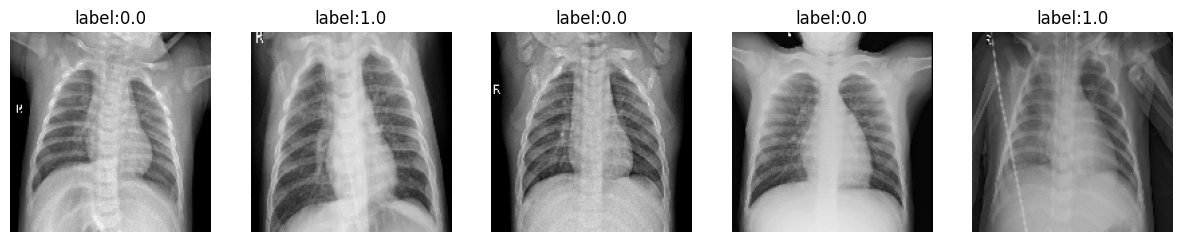

In [16]:
sample_images, sample_labels= next(train_gen)

plt.figure(figsize=(15,10))
for i in range(5):
  plt.subplot(1, 5, i+1)
  plt.imshow(sample_images[i])
  plt.title('label:{}'.format(sample_labels[i]))
  plt.axis('off')
plt.show()

# Model Development

In [17]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(32, (3,3),activation='relu', input_shape=(150, 150, 3)))
model.add(tf.keras.layers.MaxPooling2D(2, 2))
# Convolutional Layer ke 2
model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2, 2))
# Convolutional Layer ke 3
model.add(tf.keras.layers.Conv2D(128, (3,3),activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2, 2))

#Proses flattening
model.add(tf.keras.layers.GlobalAveragePooling2D())

# model.add(layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,809 (624.25 KB)

 Trainable params: 159,809 (624.25 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
callbacks=[
    EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
]

In [20]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history_cnn= model.fit(train_gen, validation_data=test_gen,
            epochs=5)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 60s 368ms/step - accuracy: 0.7439 - loss: 0.5926 - val_accuracy: 0.7276 - val_loss: 0.5325
Epoch 2/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 48s 330ms/step - accuracy: 0.7455 - loss: 0.5089 - val_accuracy: 0.8693 - val_loss: 0.3046
Epoch 3/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 49s 334ms/step - accuracy: 0.8368 - loss: 0.3478 - val_accuracy: 0.8608 - val_loss: 0.3230
Epoch 4/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 49s 331ms/step - accuracy: 0.8509 - loss: 0.3310 - val_accuracy: 0.8933 - val_loss: 0.2599
Epoch 5/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 49s 333ms/step - accuracy: 0.8650 - loss: 0.2989 - val_accuracy: 0.8992 - val_loss: 0.2527


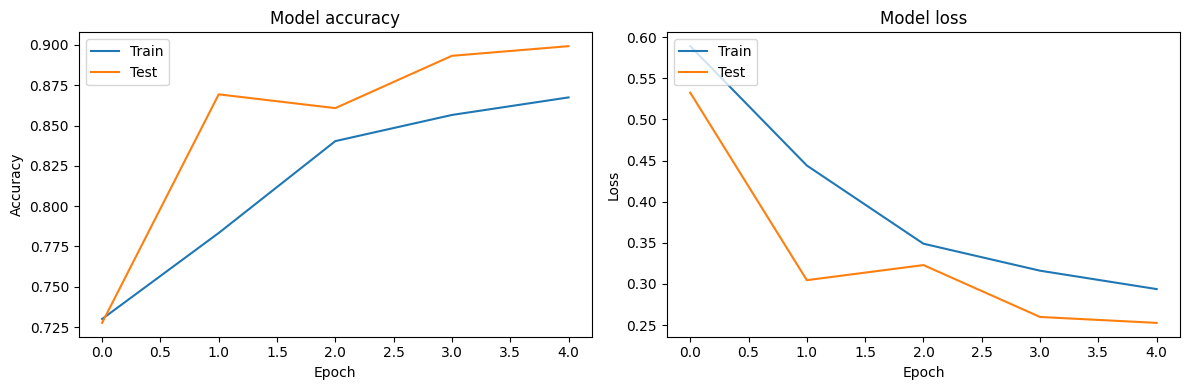

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot training & validation accuracy values
axes[0].plot(history_cnn.history['accuracy'])
axes[0].plot(history_cnn.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history_cnn.history['loss'])
axes[1].plot(history_cnn.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 274ms/step


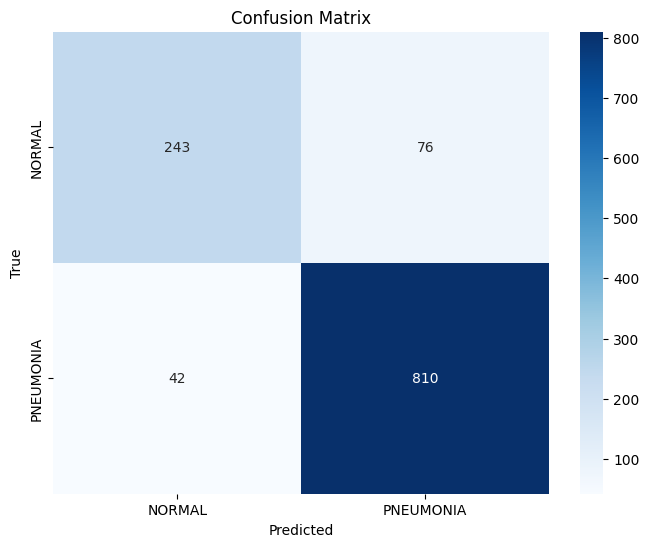

In [22]:
# Get true labels
true_labels = test_gen.classes

# Make predictions
predictions = model.predict(test_gen)
predicted_classes = (predictions > 0.5).astype(int).flatten()


# Create confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_gen.class_indices,
            yticklabels=train_gen.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [23]:
print(classification_report(true_labels, predicted_classes, target_names=list(train_gen.class_indices.keys())))

              precision    recall  f1-score   support

      NORMAL       0.85      0.76      0.80       319
   PNEUMONIA       0.91      0.95      0.93       852

    accuracy                           0.90      1171
   macro avg       0.88      0.86      0.87      1171
weighted avg       0.90      0.90      0.90      1171



# Transfer Learning

## Xception

In [43]:
inputs = Input(shape=(150, 150, 3))
model = Xception(include_top=False, weights='imagenet', input_tensor=inputs)
model.trainable = False

In [44]:
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

In [45]:
model_xception = Model(inputs=inputs, outputs=outputs)
model_xception.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_xception= model_xception.fit(train_gen, validation_data=test_gen,
            epochs=5)

Epoch 1/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 71s 424ms/step - accuracy: 0.8717 - loss: 0.3072 - val_accuracy: 0.9419 - val_loss: 0.1410
Epoch 2/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 49s 336ms/step - accuracy: 0.9359 - loss: 0.1746 - val_accuracy: 0.9505 - val_loss: 0.1215
Epoch 3/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 50s 337ms/step - accuracy: 0.9421 - loss: 0.1437 - val_accuracy: 0.9445 - val_loss: 0.1322
Epoch 4/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 50s 337ms/step - accuracy: 0.9419 - loss: 0.1538 - val_accuracy: 0.9539 - val_loss: 0.1155
Epoch 5/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 49s 336ms/step - accuracy: 0.9562 - loss: 0.1218 - val_accuracy: 0.9530 - val_loss: 0.1173


In [46]:
model_xception.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 74, 74,    │        864 │ input_layer_6[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 74, 74,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 74, 74,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 72, 72,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 72, 72,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 72, 72,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 72, 72,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 72, 72,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 72, 72,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 72, 72,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 72, 72,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 36, 36,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 36, 36,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 36, 36,    │        512 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_36 (Add)        │ (None, 36, 36,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 36, 36,    │          0 │ add_36[0][0]    

 Total params: 21,660,781 (82.63 MB)

 Trainable params: 266,433 (1.02 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

 Optimizer params: 532,868 (2.03 MB)

37/37 ━━━━━━━━━━━━━━━━━━━━ 18s 391ms/step


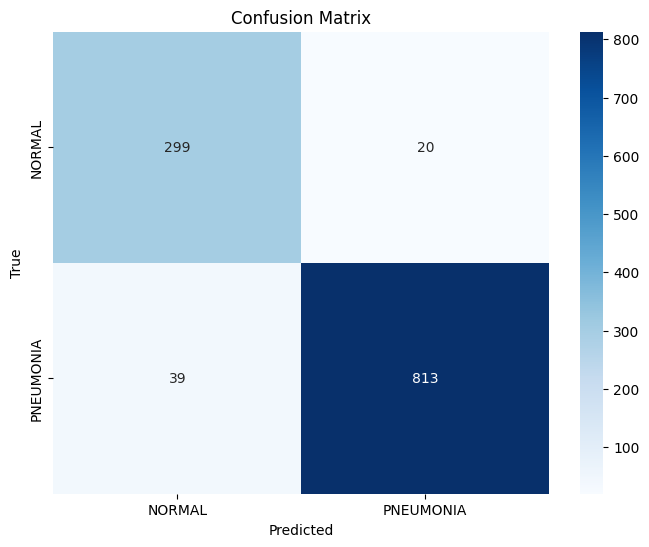

In [47]:
# Get true labels
true_labels = test_gen.classes

# Make predictions
predictions = model_xception.predict(test_gen)
predicted_classes = (predictions > 0.58).astype(int).flatten()

# Create confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_gen.class_indices,
            yticklabels=train_gen.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [48]:
print(classification_report(true_labels, predicted_classes, target_names=list(train_gen.class_indices.keys())))

              precision    recall  f1-score   support

      NORMAL       0.88      0.94      0.91       319
   PNEUMONIA       0.98      0.95      0.96       852

    accuracy                           0.95      1171
   macro avg       0.93      0.95      0.94      1171
weighted avg       0.95      0.95      0.95      1171



## Save Model

In [49]:
model_xception.save('model_xception.keras')